In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = [0]*9
        self.current_player = 1

    def legal_actions(self):
        return [i for i in range(9) if self.board[i] == 0]

    def play(self, pos):
        self.board[pos] = self.current_player
        self.current_player = -self.current_player

    def winner(self):
        wins = [
            (0,1,2),(3,4,5),(6,7,8),
            (0,3,6),(1,4,7),(2,5,8),
            (0,4,8),(2,4,6)
        ]
        for a,b,c in wins:
            if self.board[a] == self.board[b] == self.board[c] != 0:
                return self.board[a]
        return None

    def is_terminal(self):
        if self.winner() is not None:
            return True
        if 0 not in self.board:
            return True
        return False

    def reward(self):
        if self.winner() == 1:
            return 1
        elif self.winner() == -1:
            return 0
        else:
            return 0.5

Board looks like:

0 | 1 | 2
---------
3 | 4 | 5
---------
6 | 7 | 8


Values:

1 → AI (X)

-1 → Opponent (O)

0 → empty box

In [3]:
V = {}

def get_value(state):
    if state not in V:
        V[state] = 0.5
    return V[state]

In [4]:
def choose_action(env, epsilon=0.1):
    actions = env.legal_actions()

    if random.random() < epsilon:
        return random.choice(actions)

    best_value = -1
    best_action = None

    for a in actions:
        temp = env.board.copy()
        temp[a] = env.current_player
        val = get_value(tuple(temp))

        if val > best_value:
            best_value = val
            best_action = a

    return best_action

In [5]:
def update_value(state, next_state, alpha=0.1):
    if state not in V:
        V[state] = 0.5
    if next_state not in V:
        V[next_state] = 0.5

    V[state] = V[state] + alpha * (V[next_state] - V[state])

In [6]:
games = 5000
results = []

for _ in range(games):
    env = TicTacToe()
    states = []

    while not env.is_terminal():
        states.append(tuple(env.board))
        action = choose_action(env)
        env.play(action)

    r = env.reward()
    V[states[-1]] = r

    for i in range(len(states)-2, -1, -1):
        update_value(states[i], states[i+1])

    results.append(r)

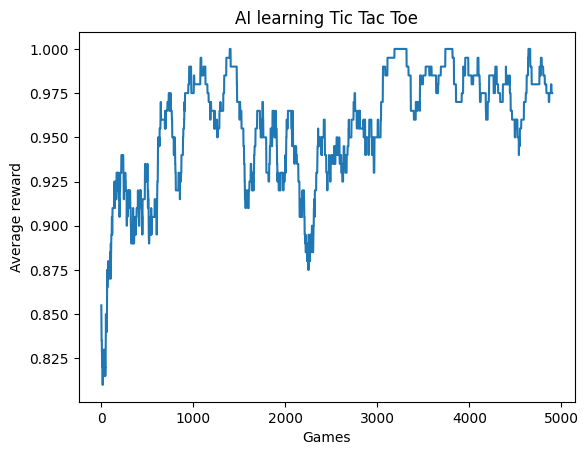

In [7]:
window = 100
smoothed = np.convolve(results, np.ones(window)/window, mode='valid')

plt.plot(smoothed)
plt.xlabel("Games")
plt.ylabel("Average reward")
plt.title("AI learning Tic Tac Toe")
plt.show()

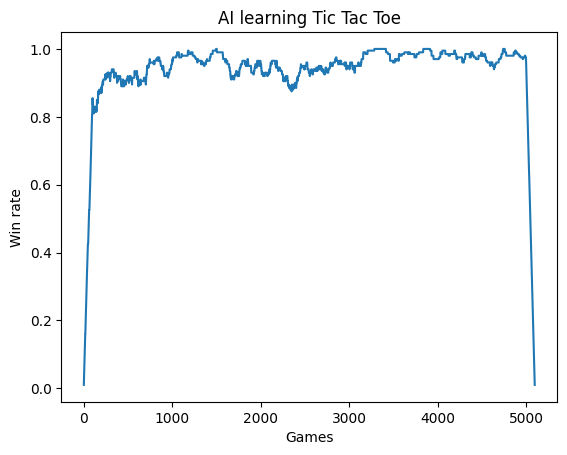

In [8]:
plt.plot(np.convolve(results, np.ones(100)/100))
plt.xlabel("Games")
plt.ylabel("Win rate")
plt.title("AI learning Tic Tac Toe")
plt.show()

LAB 2

random player starts not necessarily bot

x-> uses greedy approach

0-> e-greedy approach

keep the 4 epsilon value cases 0.01, 0.1, 0.3,0.5

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [10]:
class TicTacToe:
    def __init__(self):
        self.board = [0] * 9
        self.current_player = random.choice([1, 2])  # RANDOM START

    def legal_actions(self):
        return [i for i in range(9) if self.board[i] == 0]

    def play(self, action):
        self.board[action] = self.current_player
        self.current_player = 1 if self.current_player == 2 else 2

    def winner(self):
        wins = [
            (0,1,2),(3,4,5),(6,7,8),
            (0,3,6),(1,4,7),(2,5,8),
            (0,4,8),(2,4,6)
        ]
        for a,b,c in wins:
            if self.board[a] == self.board[b] == self.board[c] != 0:
                return self.board[a]
        return None

    def is_terminal(self):
        return self.winner() is not None or len(self.legal_actions()) == 0

    def reward(self):
        w = self.winner()
        if w == 1:
            return 1, -1
        elif w == 2:
            return -1, 1
        return 0, 0

In [11]:
V = {}

def get_value(state):
    if state not in V:
        V[state] = 0.5
    return V[state]

def update_value(state, next_state, alpha=0.1):
    if state not in V:
        V[state] = 0.5
    if next_state not in V:
        V[next_state] = 0.5

    V[state] += alpha * (V[next_state] - V[state])

In [12]:
def choose_action(env, epsilon, player):
    actions = env.legal_actions()

    # Greedy player (X)
    if player == 1:
        epsilon = 0

    if random.random() < epsilon:
        return random.choice(actions)

    best_value = -1
    best_action = None

    for a in actions:
        temp = env.board.copy()
        temp[a] = player
        val = get_value(tuple(temp))

        if val > best_value:
            best_value = val
            best_action = a

    return best_action

In [13]:
def train(epsilon_o, games=2000):
    global V
    V = {}

    rewards_x = []
    rewards_o = []

    avg_x = []
    avg_o = []

    for g in range(games):
        env = TicTacToe()
        states = []

        while not env.is_terminal():
            states.append(tuple(env.board))
            action = choose_action(
                env,
                epsilon_o,
                env.current_player
            )
            env.play(action)

        rx, ro = env.reward()
        rewards_x.append(rx)
        rewards_o.append(ro)

        V[states[-1]] = rx if env.current_player == 2 else ro

        for i in range(len(states)-2, -1, -1):
            update_value(states[i], states[i+1])

        avg_x.append(np.mean(rewards_x))
        avg_o.append(np.mean(rewards_o))

    return avg_x, avg_o

In [14]:
epsilons = [0.01, 0.1, 0.3, 0.5]
results = {}

for eps in epsilons:
    avg_x, avg_o = train(eps)
    results[eps] = (avg_x, avg_o)

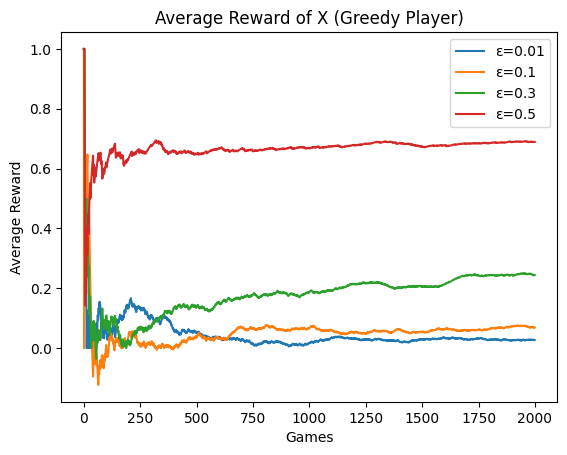

In [15]:
plt.figure()
for eps in epsilons:
    plt.plot(results[eps][0], label=f"ε={eps}")
plt.title("Average Reward of X (Greedy Player)")
plt.xlabel("Games")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

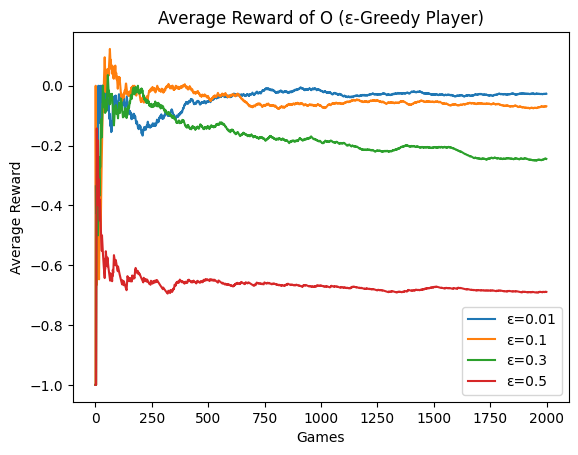

In [16]:
plt.figure()
for eps in epsilons:
    plt.plot(results[eps][1], label=f"ε={eps}")
plt.title("Average Reward of O (ε-Greedy Player)")
plt.xlabel("Games")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

In [17]:
def train(epsilon_o, games=10000):
    global V
    V = {}

    rewards_x = []
    rewards_o = []

    avg_x = []
    avg_o = []

    for g in range(games):
        env = TicTacToe()
        states = []

        while not env.is_terminal():
            states.append(tuple(env.board))
            action = choose_action(
                env,
                epsilon_o,
                env.current_player
            )
            env.play(action)

        rx, ro = env.reward()
        rewards_x.append(rx)
        rewards_o.append(ro)

        V[states[-1]] = rx if env.current_player == 2 else ro

        for i in range(len(states)-2, -1, -1):
            update_value(states[i], states[i+1])

        avg_x.append(np.mean(rewards_x))
        avg_o.append(np.mean(rewards_o))

    return avg_x, avg_o

In [18]:
epsilons = [0.01, 0.1, 0.3, 0.5]
results = {}

for eps in epsilons:
    avg_x, avg_o = train(eps)
    results[eps] = (avg_x, avg_o)

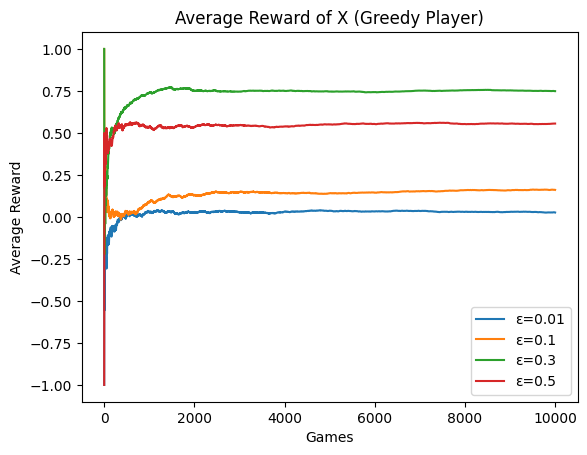

In [19]:
plt.figure()
for eps in epsilons:
    plt.plot(results[eps][0], label=f"ε={eps}")
plt.title("Average Reward of X (Greedy Player)")
plt.xlabel("Games")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

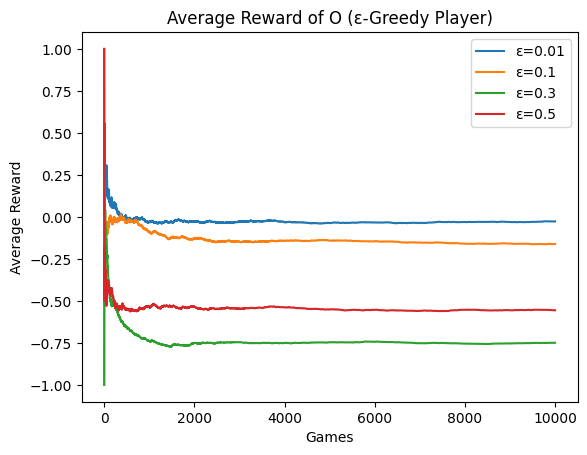

In [20]:
plt.figure()
for eps in epsilons:
    plt.plot(results[eps][1], label=f"ε={eps}")
plt.title("Average Reward of O (ε-Greedy Player)")
plt.xlabel("Games")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

In [21]:
def td_update(self, reward):
    # If no states were visited, nothing to update
    if not self.states:
        return

    # Terminal target = reward
    target = reward

    # Update from last visited state backward
    for i in reversed(range(len(self.states))):
        s_t = self.states[i]
        self.V[s_t] += self.alpha * (target - self.V[s_t])
        target = self.V[s_t]  # bootstrapping backward